In [1]:
import os
import pickle
import numpy as np
import random 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from multiprocessing import Pool, TimeoutError

from tokenizers import BertWordPieceTokenizer

import jellyfish

plt.rcParams['figure.dpi'] = 120

In [2]:
full_ocr_path = os.path.join('..', 'data', 'ocr', 'pickles', 'combined_ocr.pickle')
full_gs_path = os.path.join('..', 'data', 'ocr', 'pickles', 'combined_gs.pickle')
data_path = os.path.join('..', 'data', 'ocr', 'full')

start_position = 14

def read_ocr_file(file_path: str):
    with open(file_path, 'r', encoding='utf-8') as language_file:
        text_data: List[str] = language_file.read().split('\n')

        return(text_data[1][start_position:], text_data[2][start_position:])

def save_data_files():
    ocr_aligned_lengths = []
    gs_aligned_lengths = []
    file_paths = []

    for i, file_name in enumerate(os.listdir(data_path)):
        file_paths.append(os.path.join(data_path, file_name))

    number_of_files = len(file_paths)
    file_data = []
    for i, file_path in enumerate(file_paths):
        print(f'{i}/{number_of_files}             \r', end='')
        file_data.append(read_ocr_file(file_path))
        
    ocr_file_data = [x[0] for x in file_data]
    gs_file_data = [x[1] for x in file_data]
    
    with open(full_ocr_path, 'wb') as ocr_handle:
        pickle.dump(ocr_file_data, ocr_handle, protocol=-1)
    
    with open(full_gs_path, 'wb') as gs_handle:
        pickle.dump(gs_file_data, gs_handle, protocol=-1)
        
    return ocr_file_data, gs_file_data

if not os.path.exists(full_ocr_path) or not os.path.exists(full_gs_path):
    ocr_file_data, gs_file_data = save_data_files()
else:
    with open(full_ocr_path, 'rb') as ocr_handle:
        ocr_file_data = pickle.load(ocr_handle)
    
    with open(full_gs_path, 'rb') as gs_handle:
        gs_file_data = pickle.load(gs_handle)

In [3]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def plot_list_histogram(lst, title: str):
    labels, values = zip(*Counter(lst).items())
    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.title(title)

    plt.show()
    
def print_statistics(lst, title:str):
    max_value = np.max(lst)
    min_value = np.min(lst)
    avg_value = np.mean(lst)
    
    print(f'{title}:\nMAX: {max_value}\nMIN: {min_value}\nAVG: {avg_value}')


In [4]:
ocr_lengths = np.array([len(x) for x in ocr_file_data])
gs_lengths = np.array([len(x) for x in gs_file_data])

# indices = np.argsort(ocr_lengths)
# print(indices)


# print(ocr_file_data[0])
# ocr_file_data_np = np.array(ocr_file_data, dtype=object)
# gs_file_data_np = np.array(gs_file_data)[indices]


# plot_list_histogram(ocr_lengths, 'OCR')
# print_statistics(ocr_lengths, 'OCR')

# plot_list_histogram(gs_lengths, 'GS')
# print_statistics(gs_lengths, 'GS')

In [5]:
full_ocr_tokens_path = os.path.join('..', 'data', 'ocr', 'pickles', 'combined_ocr_tokens.pickle')
full_gs_tokens_path = os.path.join('..', 'data', 'ocr', 'pickles', 'combined_gs_tokens.pickle')

vocab_path = os.path.join('..', 'data', 'vocabularies', 'bert-base-cased-vocab.txt')
tokenizer = BertWordPieceTokenizer(vocab_path, lowercase=False)

if not os.path.exists(full_ocr_tokens_path) or not os.path.exists(full_gs_tokens_path):        
    ocr_tokens = []
    gs_tokens = []
    skipped_indices = []
    for i in range(len(ocr_file_data)):
        current_ids = tokenizer.encode(ocr_file_data[i]).ids
        if len(current_ids) > 2000:
            skipped_indices.append(i)
            continue
            
        gs_ids = tokenizer.encode(gs_file_data[i]).ids
        decoded_gs = tokenizer.decode(gs_ids)
        if (decoded_gs.count('#') / len(decoded_gs)) > 0.15:
            continue
            
        ocr_tokens.append(current_ids)
        gs_tokens.append(gs_ids)
    
    with open(full_ocr_tokens_path, 'wb') as ocr_handle:
        pickle.dump(ocr_tokens, ocr_handle, protocol=-1)
    
    with open(full_gs_tokens_path, 'wb') as gs_handle:
        pickle.dump(gs_tokens, gs_handle, protocol=-1)
    
    for index in sorted(skipped_indices, reverse=True):
        del ocr_file_data[index]
        del gs_file_data[index]

    with open(full_ocr_path, 'wb') as ocr_handle:
        pickle.dump(ocr_file_data, ocr_handle, protocol=-1)
    
    with open(full_gs_path, 'wb') as gs_handle:
        pickle.dump(gs_file_data, gs_handle, protocol=-1)
else:
    with open(full_ocr_tokens_path, 'rb') as ocr_handle:
        ocr_tokens = pickle.load(ocr_handle)
    
    with open(full_gs_tokens_path, 'rb') as gs_handle:
        gs_tokens = pickle.load(gs_handle)

In [6]:
ocr_tokens_lengths = np.array([len(x) for x in ocr_tokens])
gs_tokens_lengths = np.array([len(x) for x in gs_tokens])

# indices = np.argsort(ocr_tokens_lengths)

# ocr_tokens_lengths = np.array(ocr_tokens_lengths)[indices]
# gs_tokens_lengths = np.array(gs_tokens_lengths)[indices]
# ocr_tokens = np.array(ocr_tokens)[indices]
# gs_tokens = np.array(gs_tokens)[indices]

print(f'OCR - Less than 2000 length: {len(ocr_tokens_lengths[ocr_tokens_lengths <= 2000]) / len(ocr_tokens_lengths) * 100}')
print(f'GS  - Less than 2000 length: {len(gs_tokens_lengths[gs_tokens_lengths <= 2000]) / len(gs_tokens_lengths) * 100}')

# plot_list_histogram(ocr_tokens_lengths, 'OCR - Tokens')
# print_statistics(ocr_tokens_lengths, 'OCR - Tokens')

# plot_list_histogram(gs_tokens_lengths, 'GS - Tokens')
# print_statistics(gs_tokens_lengths, 'GS - Tokens')

OCR - Less than 2000 length: 100.0
GS  - Less than 2000 length: 99.97085869705997


In [7]:
def calculate_jaccard_similarity(list1: list, list2: list) -> float:
    set1 = set(list1)
    set2 = set(list2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_levenshtein_distance(string1: str, string2: str) -> int:
    result = jellyfish.levenshtein_distance(string1, string2)
    return result

In [8]:
def save_metrics_obj(token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances):
    metrics_path = os.path.join('..', 'data', 'ocr', 'pickles', 'metrics.pickle')

    metrics_obj = {
        'token_pairs': token_pairs,
        'decoded_pairs': decoded_pairs,
        'jaccard_similarities': jaccard_similarities,
        'levenshtein_distances': levenshtein_distances,
    }

    with open(metrics_path, 'wb') as metrics_handle:
        pickle.dump(metrics_obj, metrics_handle, protocol=-1)
        
    print('Saved metrics')

def load_metrics_obj():
    metrics_path = os.path.join('..', 'data', 'ocr', 'pickles', 'metrics.pickle')
    if not os.path.exists(metrics_path):
        return (None, None, None, None)

    with open(metrics_path, 'rb') as metrics_handle:
        metrics_obj = pickle.load(metrics_handle)
        
    return (metrics_obj['token_pairs'],
            metrics_obj['decoded_pairs'],
            metrics_obj['jaccard_similarities'],
            metrics_obj['levenshtein_distances'])
        
token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances = load_metrics_obj()

if not token_pairs:
    token_pairs = [([tokenizer.id_to_token(x) for x in ocr_tokens[i]], [tokenizer.id_to_token(x) for x in gs_tokens[i]]) for i in range(len(ocr_tokens))]
    save_metrics_obj(token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances)
    
if not decoded_pairs:
    decoded_pairs = [(ocr_file_data[i], gs_file_data[i]) for i in range(len(ocr_tokens))]
    save_metrics_obj(token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances)
    
all_pairs = len(token_pairs)
if not jaccard_similarities:
    jaccard_similarities = []
    for i, token_pair in enumerate(token_pairs):
        jaccard_similarities.append(calculate_jaccard_similarity(token_pair[0], token_pair[1]))
    
    save_metrics_obj(token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances)
    
if not levenshtein_distances:
    levenshtein_distances = []
    
if len(levenshtein_distances) < all_pairs:
    for i, decoded_pair in enumerate(decoded_pairs):
        if i < len(levenshtein_distances):
            continue
            
        print(f'LEVENSHTEIN - {i}/{all_pairs}             \r', end='')
        levenshtein_distances.append(calculate_levenshtein_distance(decoded_pair[0], decoded_pair[1]))
        
        if i % 5000 == 0:
            save_metrics_obj(token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances)
    
    save_metrics_obj(token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances)

In [9]:
def decode_string(string):
    result = string.replace(' ##', '')
    return result

In [10]:
normalized_levenshtein_distances = []
for i in range(len(decoded_pairs)):
    max_len = max(len(decoded_pairs[i][0]), len(decoded_pairs[i][1]))
    normalized_levenshtein_distances.append(float(levenshtein_distances[i]) / max_len)


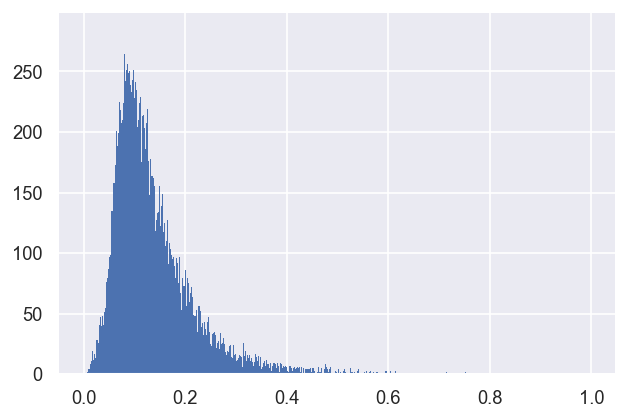

0.050284937184302554
0.1392720035078732


In [11]:
bins = np.arange(0,1, 0.001)
plt.hist(normalized_levenshtein_distances, bins = bins, edgecolor='none')
plt.show()

np_norm_ld = np.array(normalized_levenshtein_distances)
print(len(np_norm_ld[np_norm_ld > 0.3]) / len(np_norm_ld))

# for i, ld in enumerate(normalized_levenshtein_distances):
#     if ld > 0.3 and ld < 0.33 and i > 697:
#         print(i)
#         print(decode_string(decoded_pairs[i][0]))
#         print('-----------------------')
#         print(decode_string(decoded_pairs[i][1]))
#         break
        

print(np.mean(normalized_levenshtein_distances))
# print(np.argmax(normalized_levenshtein_distances))
# print(levenshtein_distances[647])
# print(decoded_pairs[647][0])
# print('-----------------------------')
# print(decoded_pairs[647][1])

# lvd_np = np.array(levenshtein_distances)
# print(len(lvd_np[lvd_np > 1000]) / len(lvd_np))
# jcd_np = np.array(jaccard_similarities)
# print(len(jcd_np[jcd_np < 0.4]) / len(jcd_np))
# print(jaccard_similarities[np.argmax(lvd_np)])
# print(decoded_pairs[np.argmax(lvd_np)][0])
# print('-------------------------------------------------')
# print(decoded_pairs[np.argmax(lvd_np)][1])

# print(f'Levenshtein distance: {np.mean(levenshtein_distances):5.2f}')
# print(f'Jaccard similarity: {np.mean(jaccard_similarities):8.2f}')



In [12]:
THRESHOLD = 0.3
LENGTH_THRESHOLD = 5000

new_indices = []
for i, nm_ld in enumerate(normalized_levenshtein_distances):
    if nm_ld > THRESHOLD:
        continue
        
    if len(decoded_pairs[i][0]) > LENGTH_THRESHOLD or len(decoded_pairs[i][1]) > LENGTH_THRESHOLD:
        continue
        
    new_indices.append(i)

In [13]:
train_pickle_path = os.path.join('..', 'data', 'ocr', 'pickles', 'train_pairs.pickle')
eval_pickle_path = os.path.join('..', 'data', 'ocr', 'pickles', 'eval_pairs.pickle')

if not os.path.exists(train_pickle_path) or not os.path.exists(eval_pickle_path):  
    eval_indices = random.sample(range(len(new_indices)), int(0.2 * len(new_indices)))

    train_pairs = []
    eval_pairs = []
    for i, new_index in enumerate(new_indices):
        if i in eval_indices:
            eval_pairs.append([token_pairs[new_index], decoded_pairs[new_index]])
        else:
            train_pairs.append([token_pairs[new_index], decoded_pairs[new_index]])

    with open(train_pickle_path, 'wb') as train_handle:
        pickle.dump(train_pairs, train_handle, protocol=-1)
    
    with open(eval_pickle_path, 'wb') as eval_handle:
        pickle.dump(eval_pairs, eval_handle, protocol=-1)

In [14]:
decoded_ocr_lengths = [len(x[0]) for x in decoded_pairs]
decoded_gs_lengths = [len(x[1]) for x in decoded_pairs]

np_ocr_lengths = np.array(decoded_ocr_lengths)
np_gs_lengths = np.array(decoded_gs_lengths)
print(len(np_ocr_lengths[np_ocr_lengths > 5000]) / len(np_ocr_lengths))
print(len(np_gs_lengths[np_gs_lengths > 5000]) / len(np_gs_lengths))

# plt.scatter(decoded_ocr_lengths, decoded_gs_lengths, s=.5)
# ident = [0.0, max(max(decoded_ocr_lengths), max(decoded_gs_lengths))]
# plt.plot(ident,ident, c='r', linewidth=1, linestyle='--')
# plt.show()

0.024316798342183654
0.025482450459785002


In [16]:
print(decoded_pairs[new_indices[0]][0])
print('---------------------------')
print(decoded_pairs[new_indices[0]][1])

bk. I, 70 AN ENGLISH ANTHOLOGY. And earthly power doth then show likest God's When mercy seasons justice. Therefore, Jew, Though justice be thy plea, consider this -That in the course of justice, none of us Should see salvation we do pray for mercy And that same prayer doth teach us all to render The deeds of mercy. 1596. - Merchant of Venice, iv. 1 LVII. THE POWER OF MUSIC. How sweet the moonlight sleeps upon this bank ! Here will we sit, and let the sounds of music Creep in our ears soft stillness and the night Become the touches of sweet harmony. Sit, Jessica. Look how the floor of heaven Is thick inlaid with patines of bright gold There's not the smallest orb which thou behold'st, But in his motion like an angel sings, Still quiring to the young-eyed cherubins Such harmony is in immortal souls But whilst this muddy vesture of decay Doth grossly close it in, we cannot hear it. Enter Musicians. Come, ho ! and wake Diana with a hymn With sweetest touches pierce your mistress' ear. And